In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u

from glob import glob
from scipy.stats import lognorm
from scipy.interpolate import interp1d
from astropy.coordinates import Distance
from frb.dm.igm import average_DM
from frb import defs
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
from matplotlib.cm import ScalarMappable

from mockFRBhosts import draw_galaxies, observed_bands, observing_time, observing_time_spectrum, draw_Delta

# Don't worry about the hmf.py module, we don't need it.

/home/jjahns/anaconda3/envs/py39/lib/python3.9/site-packages/FRB-0.1.dev0-py3.9.egg/frb/halos/hmf.py:51: UserWarning: hmf_emulator not imported.  Hope you are not intending to use the hmf.py module..
  warnings.warn("hmf_emulator not imported.  Hope you are not intending to use the hmf.py module..")


In [2]:
# Location to save figures.
fig_path = '../figures/'

if not os.path.isdir(fig_path):
    os.makedirs(fig_path)

textwidth = 7.0282  # might also be from latex textwidth=17.85162cm columnwidth=8.5744cm
columnwidth = 3.37574803  #3.3

small_size = 8
medium_size = 10
bigger_size = 12

sns.set_theme(style="ticks", context="paper")

plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)     # fontsize of the axes title
plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=bigger_size)  # fontsize of the figure title

palette = sns.color_palette('Set2')

In [3]:
# Load FRBs from the pickle files.
pickles = sorted(glob('../Simulated_FRBs/*.pickle'))

survey_models, z_models = [], []
for file in pickles:
    # Extract models from file names.
    params = os.path.basename(file)
    params = os.path.splitext(params)[0]
    params = params.split('_', 1)
    survey_models.append(params[0])
    z_models.append(params[1])

# Check files
pickles

['../Simulated_FRBs/askap-craco_sfr.pickle',
 '../Simulated_FRBs/askap-craco_smd.pickle',
 '../Simulated_FRBs/askap-craco_vol_co.pickle',
 '../Simulated_FRBs/askap-incoh_sfr.pickle',
 '../Simulated_FRBs/askap-incoh_smd.pickle',
 '../Simulated_FRBs/askap-incoh_vol_co.pickle',
 '../Simulated_FRBs/chime-frb_sfr.pickle',
 '../Simulated_FRBs/chime-frb_smd.pickle',
 '../Simulated_FRBs/chime-frb_vol_co.pickle',
 '../Simulated_FRBs/ska1-mid_sfr.pickle',
 '../Simulated_FRBs/ska1-mid_smd.pickle',
 '../Simulated_FRBs/ska1-mid_vol_co.pickle']

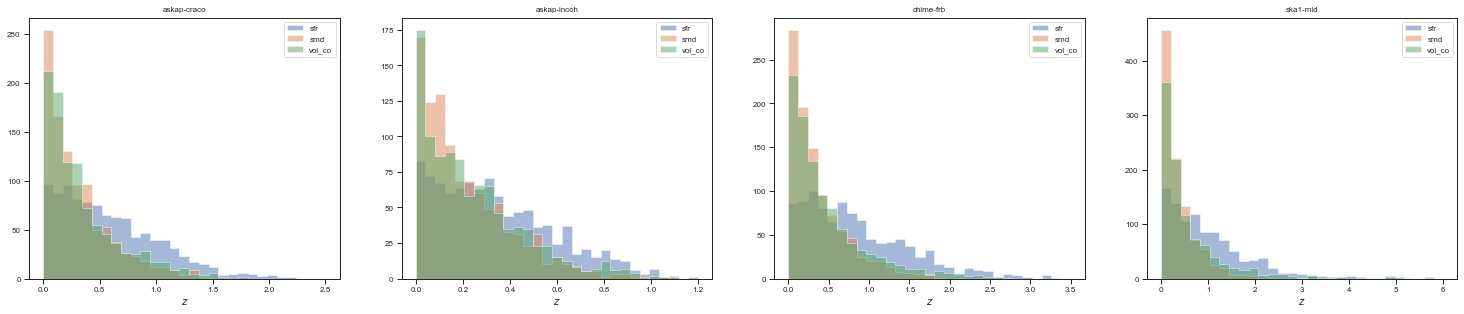

In [4]:
# Number of FRBs that should be used througout
n_frbs = 1000

# Take a peek at the redshift distributions.
n_models = len(pickles)//3
fig, axs = plt.subplots(1, n_models, figsize=(n_models*6.4, 4.8))  # figsize=(textwidth, textwidth/3*4.8/6.4)
z_max = [2.5, 1.2, 3.5, 6.]

for i, file in enumerate(pickles):
    frbs = np.load(file, allow_pickle=True)
    frbs = frbs.iloc[:n_frbs]
    ax = axs[i // 3]
    bins = np.linspace(0, z_max[i // 3], 30)
    ax.hist(frbs['z'], label=z_models[i], density=False, bins=bins, histtype='stepfilled', alpha=.5)
    ax.set_title(survey_models[i])
    ax.set_xlabel(r"$z$")
    ax.legend()

In [5]:
# Map filenames to written names.
radio_survey_names = {"askap-craco" : "ASKAP-CRACO", "askap-incoh" : "ASKAP-CRAFT", "chime-frb" : "CHIME/FRB", "meerkat" : "MeerKAT", "ska1-mid" : "SKA1-Mid"}

In [6]:
# Pick an FRB survey and redshift distribution.
i_choose = 6
chosen = pickles[i_choose]
radio_survey = survey_models[i_choose]
radio_survey_name = radio_survey_names[radio_survey]
print(chosen)

../Simulated_FRBs/chime-frb_sfr.pickle


In [7]:
# Weight galaxy choice depending on file name
if os.path.splitext(chosen)[0][-3:] == 'sfr':  # last thre letters before extension
    weights = 'mstardot'
else:
    weights = 'mstars_total'

frbs = np.load(chosen, allow_pickle=True)
print(frbs.shape[0], "FRBs in file, using only first", n_frbs)
frbs = frbs.iloc[:n_frbs].copy() 

galaxies, snapnum = draw_galaxies(frbs['z'], weights=weights, seed=42)

# Order FRBs such that they correspond to galaxies at the same positions.
frbs.loc[:, 'snapnum'] = snapnum
frbs.sort_values('snapnum', ascending=True, inplace=True)

n_bands_obs_SDSS, n_bands_obs_LSST, n_bands_obs_Euclid, n_bands_obs_DES = observed_bands(frbs, galaxies)

frbs['n_bands_SDSS'] = n_bands_obs_SDSS.to_numpy()
frbs['n_bands_LSST'] = n_bands_obs_LSST.to_numpy()
frbs['n_bands_Euclid'] = n_bands_obs_Euclid.to_numpy()
frbs['n_bands_DES'] = n_bands_obs_DES.to_numpy()

1003 FRBs in file, using only first 1000


In [8]:
# Coverage
# Chime: https://arxiv.org/pdf/2106.04353.pdf or Figure 4 in https://arxiv.org/pdf/2106.04352.pdf 
# SDSS: http://classic.sdss.org/dr7/coverage/index.html
# LSST: https://www.lsst.org/scientists/survey-design and the book there chapter 3
# Euclid: https://sci.esa.int/web/euclid/-/59042-euclid-mission-sky-coverage   Fig.2 in https://arxiv.org/pdf/1610.05508.pdf
# ASKAP: -90° < δ < ~+49° https://research.csiro.au/racs/home/survey/ 


# Redshift error

# Euclid: spectroscopic: σ(z)<0.001(1+z), from Red book: https://sci.esa.int/documents/33220/36137/1567255801368-EUCLID_RB_Issue_1-1_2011-09-29HighQ.pdf
# Photometric: Parameter Requirement            Goal 
# Redshifts error        (σ(z)/(1+z)) < 0.05     < 0.03
# Catastrophic failures 10%                      5% 
# 
# Assumed in https://arxiv.org/pdf/1606.00180.pdf  ∆z= 0.05*(1+z)

# LSST redshiftrange 0.3–3.0 with an accuracy of 1-2%, 3σ (“catastrophic”) outliers must be below 10%, bias must be below 0.003  https://www.lsst.org/scientists/publications/science-requirements-document
# 

In [9]:
# Give parameter values from which to simulate the DM. Obh70 is not used at the moment, would have to give it to averag_DM.
Obh70, F, mu, lognorm_s = cosmo.Ob0*cosmo.H0.value/70, .2, 100, 1

# Calculate the average DM up to the highest redshift, interpolate to avoid using this slow function again.
# (For every neval an integral is done in frb.dm.igm.avg_rhoISM when cosmo.age(z) is called.)
DM_cum, zeval = average_DM(frbs['z'].max(), cosmo=defs.frb_cosmo, cumul=True)
avrg_DM = interp1d(zeval, DM_cum, assume_sorted=True)

# Draw a DM_IGM from it's PDF. Multiply by <DM_cosmic> to get a DM.
rng = np.random.default_rng(seed=42)
delta = [float(draw_Delta(z, f=F, n_samples=1, rng=rng)) for z in frbs['z']]
dm_cosmic = np.array(delta) * avrg_DM(frbs['z'])

# Draw a DM_host from the parameters that Macquart2020 gives.
dm_host = lognorm.rvs(lognorm_s, scale=mu, size=len(frbs['z']))

frbs['DM'] = dm_host/(1+frbs['z']) + dm_cosmic

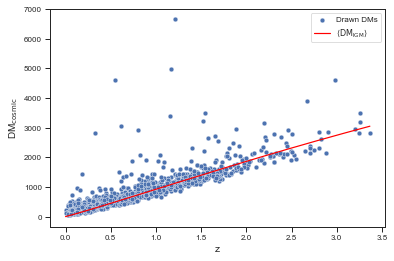

In [10]:
# Plot distributions to see their worth.
plt.close('all')
fig, ax = plt.subplots()
# Plot the data.
sns.scatterplot(x=frbs['z'], y=frbs['DM'], ax=ax, label="Drawn DMs")
ax.set_xlabel("z")
ax.set_ylabel(r"DM$_\mathrm{cosmic}$")

z = np.linspace(0, frbs['z'].max(), 1000)
sns.lineplot(x=z, y=avrg_DM(z), ax=ax, color='red', label=r"$\langle \mathrm{DM}_\mathrm{IGM}\rangle$")

ax.legend()

Text(0.5, 0, '$\\mathrm{DM}_\\mathrm{host}$')

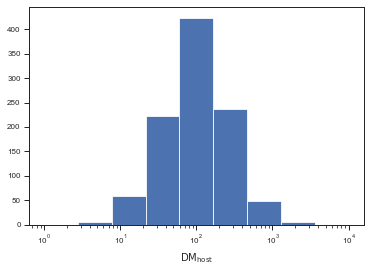

In [11]:
fig, ax = plt.subplots()
ax.hist(dm_host, bins=np.logspace(0, 4, 10))
#ax.hist(dm_host2, bins=np.logspace(0, 4, 10), color='red')
plt.xscale('log')
plt.xlabel("$\mathrm{DM}_\mathrm{host}$")

In [12]:
# Pick an optical survey.
survey = 'SDSS'
n_bands_obs = frbs['n_bands_' + survey]
n_bands = n_bands_obs.max()

In [13]:
# Get apparent magnitudes in SDSS
frb_zs = frbs['z'].to_numpy()
dist = Distance(z=frb_zs, cosmology=cosmo)
apparent_mag = (dist.distmod.value[:, np.newaxis] + 5*np.log10(cosmo.h)
                    - 2.5*np.log10(1+frb_zs)[:, np.newaxis]
                    + galaxies.loc[:, 'mag_SDSS-u_tot':'mag_SDSS-z_tot'])

In [14]:
# Calculate the Galaxy size assuming a size of 4 arcsec^2 at 1 Gpc distance, which is around 10 kpc diameter.
gal_size = 4 * (1*u.Gpc/cosmo.angular_diameter_distance(frb_zs)).decompose()**2

# Calculate the observing time needed to see a galaxy in one band with a 10m telescope.
obs_time = observing_time(apparent_mag['mag_SDSS-r_tot'], snr=10, gal_size=gal_size)
obs_time_spec = observing_time_spectrum(apparent_mag['mag_SDSS-r_tot'], snr=10, gal_diam=np.sqrt(gal_size))

# Save it and make different arrays with visible glaxies etc.
frbs['obs_time'] = obs_time.to_numpy()
frbs['obs_time_spec'] = obs_time_spec.to_numpy()

frbs_wo_host = frbs[n_bands_obs.to_numpy() == 0].sort_values('z', ascending=True)
frb_in_some_band = frbs[(n_bands_obs < n_bands) & (n_bands_obs > 0)].sort_values('z', ascending=True)

obs_time = frbs['obs_time']
obs_time_wo_host = frbs_wo_host['obs_time']
obs_time_isb = frb_in_some_band['obs_time']

In [15]:
# Calculate conversion factor to observe with a spectrometer
phi_glaxy = 1  # width of galaxy on the sky (arcsec)
diameter = 1000
wp = 0.003  # w': reimaged slit at camera focus (cm) (equivalent to 30um)
r = 0.9  # anamorphic magnification
F_2 = 1.5  # camera optics focal length / diameter of collimated beam, incident on the disperser (p. 308)
phi1 = wp/(r*diameter*F_2)*180*3600/np.pi  # convert to arcsec

band_phot = 100 # bandpass (nm)
line_width = 1  # spectral line width (nm)

spec_conv = band_phot/line_width * phi_glaxy/phi1

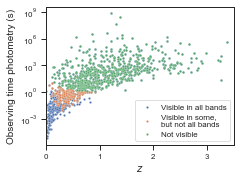

In [16]:
# Plot photometric time vs. z
fig, ax = plt.subplots(figsize=(columnwidth, columnwidth*4.8/6.4))
sns.scatterplot(x=frbs['z'], y=obs_time, ax=ax, label="Visible in all bands", s=5)
sns.scatterplot(x=frb_in_some_band['z'], y=obs_time_isb, ax=ax, label="Visible in some,\nbut not all bands", s=5)
sns.scatterplot(x=frbs_wo_host['z'], y=obs_time_wo_host, ax=ax, label="Not visible", s=5)

# Make a theoretical line
# z = np.linspace(.03, 3.3, 100)
# plt.plot(z, cosmo.luminosity_distance(z).to(u.Gpc)**4/1e-1, label="$D_\mathrm{lum}^4$ (arb. units)", lw=.5)

ax.set_xlim(0, 3.5)
ax.set_yscale('log')
ax.set_xlabel("$z$")
ax.set_ylabel("Observing time photometry (s)")
ax.legend(loc='lower right')
ax.set_yticks([10**n for n in range(-3, 10, 3)])
ax.set_xticks([0,1,2,3])

fig.savefig(fig_path + "obs_time.pdf", bbox_inches='tight', dpi=300)

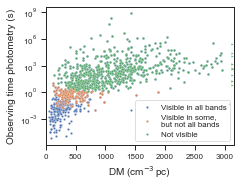

In [17]:
# Plot photometric time vs. DM
fig, ax = plt.subplots(figsize=(columnwidth, columnwidth*4.8/6.4))
x_lim = average_DM(3.5, cosmo=defs.frb_cosmo, cumul=False).value  # upper limit x-axis

sns.scatterplot(x=frbs['DM'], y=obs_time, ax=ax, label="Visible in all bands", s=5)
sns.scatterplot(x=frb_in_some_band['DM'], y=obs_time_isb, ax=ax, label="Visible in some,\nbut not all bands", s=5)
sns.scatterplot(x=frbs_wo_host['DM'], y=obs_time_wo_host, ax=ax, label="Not visible", s=5)
sns.scatterplot(x=x_lim-30, y=obs_time_wo_host[frbs_wo_host['DM'] > x_lim], ax=ax, s=5, color='g', marker='>')

ax.set_xlim(0, x_lim)
ax.set_yscale('log')
ax.set_xlabel("DM (cm$^{-3}\,$pc)")
ax.set_ylabel("Observing time photometry (s)")
ax.legend(loc='lower right')
ax.set_yticks([10**n for n in range(-3, 10, 3)])

fig.savefig(fig_path + "obs_time_vs_DM.pdf", bbox_inches='tight')

In [18]:
obs_time = frbs['obs_time_spec']
obs_time_wo_host = frbs_wo_host['obs_time_spec']
obs_time_isb = frb_in_some_band['obs_time_spec']

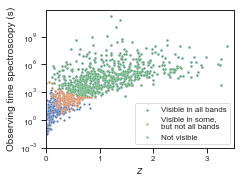

In [19]:
# Plot spectroscopic time vs. z
fig, ax = plt.subplots(figsize=(columnwidth, columnwidth*4.8/6.4))
x_lim = average_DM(3.5, cosmo=defs.frb_cosmo, cumul=False).value  # upper limit x-axis

sns.scatterplot(x=frbs['z'], y=obs_time, ax=ax, label="Visible in all bands", s=5)
sns.scatterplot(x=frb_in_some_band['z'], y=obs_time_isb, ax=ax, label="Visible in some,\nbut not all bands", s=5)
sns.scatterplot(x=frbs_wo_host['z'], y=obs_time_wo_host, ax=ax, label="Not visible", s=5)

ax.set_xlim(0, 3.5)
ax.set_yscale('log')
ax.set_xlabel("$z$")
ax.set_ylabel("Observing time spectroscopy (s)")
ax.legend(loc='lower right')
ax.set_yticks([10**n for n in range(-3, 10, 3)])
ax.set_xticks([0,1,2,3])

fig.savefig(fig_path + "obs_time_spec.pdf", bbox_inches='tight')

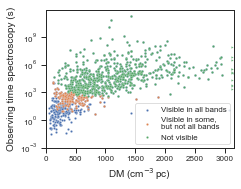

In [20]:
# Plot spectroscopic time vs. DM
fig, ax = plt.subplots(figsize=(columnwidth, columnwidth*4.8/6.4))
x_lim = average_DM(3.5, cosmo=defs.frb_cosmo, cumul=False).value  # upper limit x-axis

sns.scatterplot(x=frbs['DM'], y=obs_time, ax=ax, label="Visible in all bands", s=5)
sns.scatterplot(x=frb_in_some_band['DM'], y=obs_time_isb, ax=ax, label="Visible in some,\nbut not all bands", s=5)
sns.scatterplot(x=frbs_wo_host['DM'], y=obs_time_wo_host, ax=ax, label="Not visible", s=5)
sns.scatterplot(x=x_lim-30, y=obs_time_wo_host[frbs_wo_host['DM'] > x_lim], ax=ax, s=5, color='g', marker='>')

ax.set_xlim(0, x_lim)
ax.set_yscale('log')
ax.set_xlabel("DM (cm$^{-3}\,$pc)")
ax.set_ylabel("Observing time spectroscopy (s)")
ax.legend(loc='lower right')
ax.set_yticks([10**n for n in range(-3, 10, 3)])

fig.savefig(fig_path + "obs_time_vs_DM_spec.pdf", bbox_inches='tight')

/tmp/ipykernel_105563/2704167266.py:4: RuntimeWarning: divide by zero encountered in true_divide
  uncert_DM = np.sqrt((100*np.sqrt(np.exp(2*lognorm_s)-np.exp(lognorm_s))/(1+z))**2 + (0.2*avrg_DM(z)/np.sqrt(z))**2)


Text(0, 0.5, "'Cosmological Signal'$^2$")

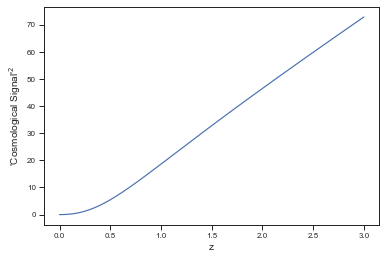

In [21]:
# Plot the squared cosmological signal against redshift, this is what would be added under a square root to the SNR from previous measurements.
z = np.linspace(0, 3, 1000)

uncert_DM = np.sqrt((100*np.sqrt(np.exp(2*lognorm_s)-np.exp(lognorm_s))/(1+z))**2 + (0.2*avrg_DM(z)/np.sqrt(z))**2)
rel_DM_uncert = uncert_DM/avrg_DM(z)

plt.plot(z, 1/rel_DM_uncert**2,)
plt.xlabel("z")
plt.ylabel("'Cosmological Signal'$^2$")

Text(0, 0.5, "'Cosmological Signal'")

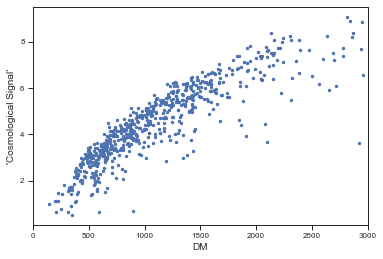

In [22]:
# Calculate the relative DM uncertainty, which is 1/SNR_cosmic.
uncert_DM = np.sqrt((100*np.sqrt(np.exp(2*lognorm_s)-np.exp(lognorm_s))/(1+frbs_wo_host['z']))**2 + (0.2*avrg_DM(frbs_wo_host['z'])/np.sqrt(frbs_wo_host['z']))**2)
rel_DM_uncert = uncert_DM/avrg_DM(frbs_wo_host['z'])

plt.plot(frbs_wo_host['DM'], 1/rel_DM_uncert, '.') #obs_time_wo_host,
plt.xlim(0,3000)
# plt.xscale('log')

plt.xlabel("DM")
plt.ylabel("'Cosmological Signal'")

In [23]:
obs_time = frbs['obs_time']
obs_time_wo_host = frbs_wo_host['obs_time']
obs_time_isb = frb_in_some_band['obs_time']

In [24]:
# Loop over some DM ranges to see how cosmological SNR and efficiancy changes with time.
time_limit = np.logspace(np.log10(obs_time_wo_host.min()), np.log10(obs_time_wo_host.max()), 1000)  # Observing time limit, from maximum observing time till the median.

DM_ranges = [[500, 800], [0, 800], [0, 1000], [0, 10000]]
total_time = np.zeros((len(DM_ranges), time_limit.shape[0]))
n_observed = np.zeros((len(DM_ranges), time_limit.shape[0]), dtype=int)
n_weighted = np.zeros((len(DM_ranges), time_limit.shape[0]))
for j, (min_DM, max_DM) in enumerate(DM_ranges):
    obs_time_in_range = obs_time_wo_host[(frbs_wo_host['DM'] > min_DM) & (frbs_wo_host['DM'] < max_DM)]
    rel_DM_uncert_in_range = rel_DM_uncert[(frbs_wo_host['DM'] > min_DM) & (frbs_wo_host['DM'] < max_DM)]
    for i, tl in enumerate(time_limit):
        observable = obs_time_in_range < tl
        n_observed[j, i] = np.count_nonzero(observable)
        n_weighted[j, i] = np.sqrt(np.sum(1/rel_DM_uncert_in_range[observable]**2))

        # Save the time of observing galaxies and the time wasted on galaxies below the limit.
        total_time[j, i] = obs_time_in_range[observable].sum() + tl*(len(obs_time_in_range)-n_observed[j, i])

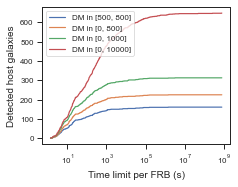

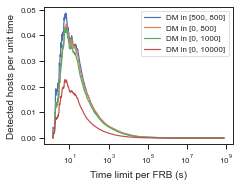

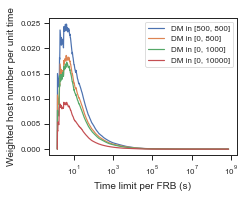

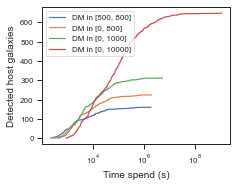

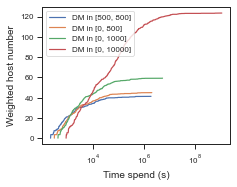

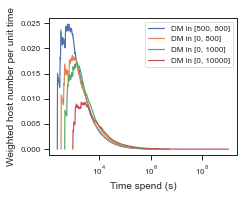

In [25]:
for x_axis, y_axis, xlabel, ylabel in [[len(DM_ranges)*[time_limit], n_observed, "Time limit per FRB (s)", "Detected host galaxies"],
                                       [len(DM_ranges)*[time_limit], n_observed/total_time, "Time limit per FRB (s)", "Detected hosts per unit time"],
                                       [len(DM_ranges)*[time_limit], n_weighted/total_time, "Time limit per FRB (s)", "Weighted host number per unit time"],
                                       [total_time, n_observed, "Time spend (s)", "Detected host galaxies"],
                                       [total_time, n_weighted, "Time spend (s)", "Weighted host number"],
                                       [total_time, n_weighted/total_time, "Time spend (s)", "Weighted host number per unit time"],
                                      ]:
                                       
    fig, ax = plt.subplots(figsize=(columnwidth, columnwidth*4.8/6.4))

    for j, (min_DM, max_DM) in enumerate(DM_ranges):
        ax.plot(x_axis[j], y_axis[j], label=f"DM in [{min_DM}, {max_DM}]")
    # ax.invert_xaxis()
    ax.set_xscale('log')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    # if xlabel == "Time spend (s)":
    #     ax.set_xlim(None, 1e4)
    # else:
    #     ax.set_xlim(None, 1e2)

In [26]:
# Change the central DM, keep the FRB number equal.
central_DMs = np.arange(200, 1000, 100)

total_time = np.zeros((len(central_DMs), time_limit.shape[0]))
n_observed = np.zeros((len(central_DMs), time_limit.shape[0]), dtype=int)
n_weighted = np.zeros((len(central_DMs), time_limit.shape[0]))
for j, central_DM in enumerate(central_DMs):
    diff_DM = (frbs_wo_host['DM'] - central_DM).abs()
    obs_order = np.argsort(diff_DM).to_numpy()
    obs_time_in_range = obs_time_wo_host.iloc[obs_order].iloc[:100]
    rel_DM_uncert_in_range = rel_DM_uncert.iloc[obs_order].iloc[:100]
    for i, tl in enumerate(time_limit):
        observable = obs_time_in_range < tl
        n_observed[j, i] = np.count_nonzero(observable)
        n_weighted[j, i] = np.sum(1/rel_DM_uncert_in_range[observable]**2)

        # Save the time of observing galaxies and the time wasted on galaxies below the limit.
        total_time[j, i] = obs_time_in_range[observable].sum() + tl*(len(obs_time_in_range)-n_observed[j, i])


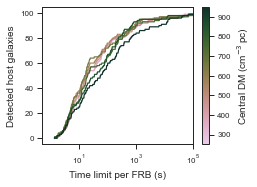

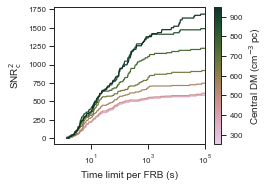

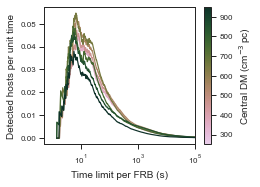

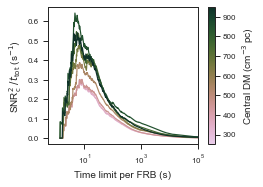

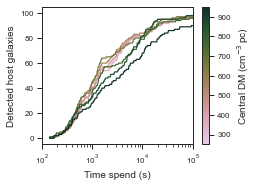

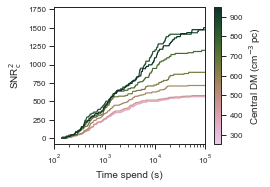

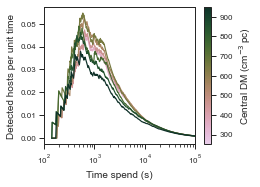

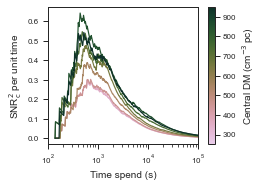

In [27]:
cmap = sns.cubehelix_palette(start=-.3, rot=-.9, as_cmap=True)
trace_color = cmap(np.linspace(0, 1, len(central_DMs)))

for x_axis, y_axis, xlabel, ylabel, fig_name in [[len(central_DMs)*[time_limit], n_observed, "Time limit per FRB (s)", "Detected host galaxies", None],
                                                 [len(central_DMs)*[time_limit], n_weighted, "Time limit per FRB (s)", "SNR$_\mathrm{c}^2$", None],
                                                 [len(central_DMs)*[time_limit], n_observed/total_time, "Time limit per FRB (s)", "Detected hosts per unit time", None],
                                                 [len(central_DMs)*[time_limit], n_weighted/total_time, "Time limit per FRB (s)", "SNR$_\mathrm{c}^2$ $/ t_\mathrm{tot}$ (s$^{-1}$)", "DM_vs_s_per_time_vs_limit"],
                                                 [total_time, n_observed, "Time spend (s)", "Detected host galaxies", "DM_vs_ndetected_vs_time"],
                                                 [total_time, n_weighted, "Time spend (s)", "SNR$_\mathrm{c}^2$", "DM_vs_signal_vs_time"],
                                                 [total_time, n_observed/total_time, "Time spend (s)", "Detected hosts per unit time", "DM_vs_n_per_time_vs_time"],
                                                 [total_time, n_weighted/total_time, "Time spend (s)", "SNR$_\mathrm{c}^2$ per unit time", "DM_vs_s_per_time_vs_time"],
                                                ]:

    fig, ax = plt.subplots(figsize=(columnwidth, columnwidth*4.8/6.4))
    
    for j, num in enumerate(central_DMs):
        ax.plot(x_axis[j], y_axis[j], color=trace_color[j], )  #linewidth=.5

    ax.set_xscale('log')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    mapp = ScalarMappable(cmap=cmap, norm=plt.Normalize(central_DMs.min()+50, central_DMs.max()+50))
    cbar = plt.colorbar(mapp, ticks=central_DMs[0::], label=r'Central DM (cm$^{-3}\,$pc)')
    if xlabel == "Time spend (s)":
        ax.set_xlim(1e2, 1e5)
    else:
        ax.set_xlim(None, 1e5)
    if fig_name:
        fig.savefig(fig_path + fig_name + ".png", dpi=300, bbox_inches='tight')

In [28]:
# Loop over DM and time limit to find the best DM.
time_limit = np.logspace(np.log10(obs_time_wo_host.min()), 3, 500)

obs_order = np.argsort(frbs_wo_host['DM'].to_numpy())
dms = frbs_wo_host['DM'].iloc[obs_order]
obs_time_sorted = obs_time_wo_host.iloc[obs_order]
rel_DM_uncert_sorted = rel_DM_uncert.iloc[obs_order]

sample_size = 100
samples = len(frbs_wo_host)-sample_size
central_DMs = np.zeros((samples,))
total_time = np.zeros((samples, time_limit.shape[0]))
n_observed = np.zeros((samples, time_limit.shape[0]), dtype=int)
n_weighted = np.zeros((samples, time_limit.shape[0]))
for j, i_start in enumerate(np.arange(0, samples)):
    if j % 100 == 0:
        print(f"{j/samples:.0%} complete")
    obs_time_in_range = obs_time_sorted.iloc[i_start:i_start+sample_size]
    rel_DM_uncert_in_range = rel_DM_uncert_sorted.iloc[i_start:i_start+sample_size]
    
    dms_in_range = dms.iloc[i_start:i_start+sample_size]
    central_DMs[j] = (dms_in_range.max()+dms_in_range.min()) / 2
    for i, tl in enumerate(time_limit):
        observable = obs_time_in_range < tl
        n_observed[j, i] = np.count_nonzero(observable)
        n_weighted[j, i] = np.sum(1/rel_DM_uncert_in_range[observable]**2)

        # Save the time of observing galaxies and the time wasted on galaxies below the limit.
        total_time[j, i] = obs_time_in_range[observable].sum() + tl*(len(obs_time_in_range)-n_observed[j, i])


0% complete
18% complete
36% complete
55% complete
73% complete
91% complete


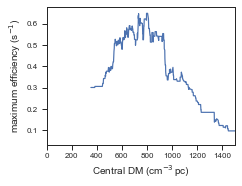

In [29]:
# Plot the maximum efficiency of each 
fig, ax = plt.subplots(figsize=(columnwidth, columnwidth*4.8/6.4))
# ax.plot(time_limit, n_weighted[-1], )
ax.plot(central_DMs, np.max(n_weighted/total_time, axis=1), '-')
ax.set_xlim(0, 1500)
ax.set_xlabel("Central DM (cm$^{-3}\,$pc)")
ax.set_ylabel("maximum efficiency (s$^{-1}$)")  #'Cosmological signal' $/ t_\mathrm{tot}$
ax.set_xticks(np.arange(0, 1501, 200))
fig.savefig(fig_path + "DM_vs_s_per_time.png", dpi=300, bbox_inches='tight')

In [30]:
max_i = np.argmax(np.max(n_weighted/total_time, axis=1))
print(f"The DM with the highest efficiency is {central_DMs[max_i]:.1}")

The DM with the highest efficiency is 8e+02


In [31]:
# Vary the number, with the best DM fixed.
time_limit = np.logspace(np.log10(obs_time_wo_host.min()), np.log10(obs_time_wo_host.max()), 1000)

central_DM = central_DMs[max_i]
diff_DM = (frbs_wo_host['DM'] - central_DM).abs()
obs_order = np.argsort(diff_DM).to_numpy()

n_select = np.arange(40, len(obs_time_wo_host), 40)
total_time = np.zeros((len(n_select), time_limit.shape[0]))
n_observed = np.zeros((len(n_select), time_limit.shape[0]), dtype=int)
n_weighted = np.zeros((len(n_select), time_limit.shape[0]))
for j, num in enumerate(n_select):
    obs_time_in_range = obs_time_wo_host.iloc[obs_order].iloc[:num]
    rel_DM_uncert_in_range = rel_DM_uncert.iloc[obs_order].iloc[:num]
    for i, tl in enumerate(time_limit):
        observable = obs_time_in_range < tl
        n_observed[j, i] = np.count_nonzero(observable)
        n_weighted[j, i] = np.sum(1/rel_DM_uncert_in_range[observable]**2)

        # Save the time of observing galaxies and the time wasted on galaxies below the limit.
        total_time[j, i] = obs_time_in_range[observable].sum() + tl*(len(obs_time_in_range)-n_observed[j, i])

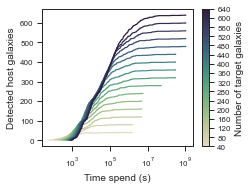

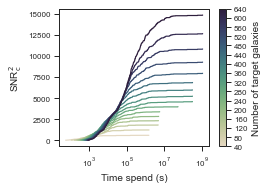

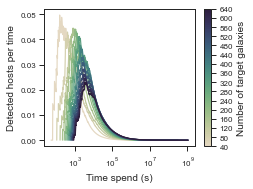

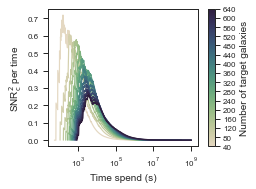

In [32]:
cmap = sns.cubehelix_palette(start=.6, rot=-.9, as_cmap=True)
trace_color = cmap(np.linspace(0, 1, len(n_select)))

for x_axis, y_axis, xlabel, ylabel, fig_name in [#[len(n_select)*[time_limit], n_observed, "Time limit per FRB (s)", "Detected host galaxies"],
                                                 # [len(n_select)*[time_limit], n_observed/total_time, "Time limit per FRB (s)", "Detected hosts per unit time", ],
                                                 # [len(n_select)*[time_limit], n_weighted/total_time, "Time limit per FRB (s)", "Weighted host number per unit time"],
                                                 [total_time, n_observed, "Time spend (s)", "Detected host galaxies", "n_gal_vs_ndetected_vs_time"],
                                                 [total_time, n_weighted, "Time spend (s)", "SNR$_\mathrm{c}^2$", "n_gal_vs_signal_vs_time"],
                                                 [total_time, n_observed/total_time, "Time spend (s)", "Detected hosts per time", "n_gal_vs_n_per_time_vs_time"],
                                                 [total_time, n_weighted/total_time, "Time spend (s)", "SNR$_\mathrm{c}^2$ per time", "n_gal_vs_s_per_time_vs_time"],
                                                ]:

    fig, ax = plt.subplots(figsize=(columnwidth, columnwidth*4.8/6.4))
    
    # cmap = sns.color_palette("cubehelix", n_colors=len(n_select))
    
    for j, num in enumerate(n_select):
        ax.plot(x_axis[j], y_axis[j], color=trace_color[j])
    # ax.invert_xaxis()
    ax.set_xscale('log')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    mapp = ScalarMappable(cmap=cmap, norm=plt.Normalize(n_select.min(), n_select.max()))
    cbar = plt.colorbar(mapp, ticks=n_select[::], label=r'Number of target galaxies')
    # if xlabel == "Time spend (s)":
    #     ax.set_xlim(None, 1e4)
    # else:
    #     ax.set_xlim(None, 1e2)
    # if fig_name:
    #     fig.savefig(fig_path + fig_name + ".png", dpi=300, bbox_inches='tight')

In [33]:
# Sort by distance from a central DM, but keep the one below 700 first (changed to 1000)
central_DM = round(central_DMs[max_i]/100)*100  # picking the DM too precise can end um in a local efficiency spike.
DM_limit = 1000
diff_DM = (frbs_wo_host['DM'] - central_DM).abs()
less700 = (frbs_wo_host['DM'] < DM_limit).to_numpy()

obs_order1 = np.argsort(diff_DM[less700]).to_numpy()
obs_order1 = np.arange(len(frbs_wo_host))[less700][obs_order1]
obs_order2 = np.argsort(diff_DM[~less700]).to_numpy()
obs_order2 = np.arange(len(frbs_wo_host))[~less700][obs_order2]

obs_order = np.concatenate([obs_order1, obs_order2])

(0.0, 1000.0)

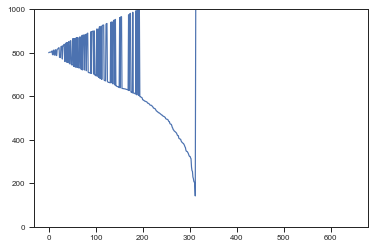

In [34]:
plt.plot(np.arange(len(frbs_wo_host)), frbs_wo_host['DM'].iloc[obs_order])
plt.ylim(0, 1000)

In [35]:
# Implement the algorithm to balance the number that is followed up and time limit to get the highest observed number, ignoring the DM.
n_gals = []
t_tot = []
n_obsed = []
c_signal = [] 
time_limits = []
tl = time_limit[np.argmax(n_observed/total_time, axis=1)[0]]*3/4
n_gal = n_select[1]
n_obs = 0

while n_obs < len(frbs_wo_host):
    obs_time_in_range = obs_time_wo_host.iloc[obs_order].iloc[:n_gal]
    rel_DM_uncert_in_range = rel_DM_uncert.iloc[obs_order].iloc[:n_gal]
    observable = obs_time_in_range <= tl
    n_obs = np.count_nonzero(observable)
    n_obsed.append(n_obs)
    
    n_gals.append(n_gal)
    time_limits.append(tl)
    t_tot.append(obs_time_in_range[observable].sum() + tl*(len(obs_time_in_range)-n_obs))
    c_signal.append(np.sum(1/rel_DM_uncert_in_range[observable]**2))
    del_n = min(10, n_obs)
    derivative = (obs_time_in_range[observable].max() - obs_time_in_range[observable].sort_values().iloc[-del_n]) / (del_n-1)
    reference = (t_tot[-1]/n_obs) / (n_gal - n_obs)
    
    if ((derivative < reference) or (n_gal == len(frbs_wo_host))) and (n_obs < n_gal):
        tl = obs_time_in_range[~observable].min()
    else:
        n_gal += 1
    
n_gals = np.array(n_gals)
t_tot = np.array(t_tot)
n_obsed = np.array(n_obsed)
c_signal = np.array(c_signal)
time_limits = np.array(time_limits)

/tmp/ipykernel_105563/2186530361.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  reference = (t_tot[-1]/n_obs) / (n_gal - n_obs)


In [36]:
# Use a different strategy that increases tl for DMs > 1000
avrg_z = interp1d(DM_cum, zeval, assume_sorted=True)
max_DM = DM_cum.max().value

n_gals2 = []
t_tot2 = []
n_obsed2 = []
c_signal2 = [] 
time_limits2 = []

tl = time_limit[np.argmax(n_observed/total_time, axis=1)[0]]*3/4
n_gal = n_select[1]
n_obs = 0
tl_700 = None

while n_obs < len(frbs_wo_host):
    obs_time_in_range = obs_time_wo_host.iloc[obs_order].iloc[:n_gal]
    rel_DM_uncert_in_range = rel_DM_uncert.iloc[obs_order].iloc[:n_gal]
    observable = obs_time_in_range <= tl
    n_obs = np.count_nonzero(observable)
    n_obsed2.append(n_obs)
    
    n_gals2.append(n_gal)
    time_limits2.append(tl)
    t_tot2.append(obs_time_in_range[observable].sum() + tl*(len(obs_time_in_range)-n_obs))
    c_signal2.append(np.sum(1/rel_DM_uncert_in_range[observable]**2))
    del_n = min(10, n_obs)
    derivative = (obs_time_in_range[observable].max() - obs_time_in_range[observable].sort_values().iloc[-del_n]) / (del_n-1)
    reference = (t_tot2[-1]/n_obs) / (n_gal - n_obs)
    
    if not tl_700 and (frbs_wo_host['DM'].iloc[obs_order].iloc[n_gal:] > DM_limit).all():
        print(n_gal)
        tl_700 = tl
        dm_700 = frbs_wo_host['DM'].iloc[obs_order].iloc[n_gal]
        d_l_700 = cosmo.luminosity_distance(avrg_z(dm_700)).to(u.Gpc)
    if tl_700 and n_gal_raised and (n_gal < len(frbs_wo_host)):
        # Compute new tl_at next DM
        next_DM = frbs_wo_host['DM'].iloc[obs_order].iloc[n_gal]
        if next_DM < max_DM:  # If the DM is above the definition range of avrg_z, don't raise tl_DM no more
            d_l = cosmo.luminosity_distance(avrg_z(next_DM)).to(u.Gpc)
            tl_DM = (d_l/d_l_700)**4*tl_700

    if ((derivative < reference) or (n_gal == len(frbs_wo_host)) or (tl_700 and (tl<tl_DM))) and (n_obs < n_gal):
        tl = obs_time_in_range[~observable].min()
        n_gal_raised = False
    else:
        n_gal += 1
        n_gal_raised = True
    
n_gals2 = np.array(n_gals2)
t_tot2 = np.array(t_tot2)
n_obsed2 = np.array(n_obsed2)
c_signal2 = np.array(c_signal2)
time_limits2 = np.array(time_limits2)

313


/tmp/ipykernel_105563/4211133781.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  reference = (t_tot2[-1]/n_obs) / (n_gal - n_obs)


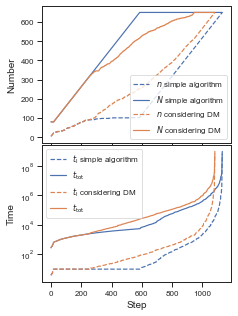

In [37]:
# Plot the results of the two algorithms to see what they do.
fig, axs = plt.subplots(2, sharex=True, figsize=(columnwidth, 2*columnwidth*4.8/6.4), gridspec_kw={'hspace':0.02})
axs[0].plot(np.arange(len(n_obsed)), n_obsed, 'C0--', label="$n$ simple algorithm")
axs[0].plot(np.arange(len(n_obsed)), n_gals, 'C0-', label="$N$ simple algorithm")
axs[0].plot(np.arange(len(n_obsed2)), n_obsed2, 'C1--', label="$n$ considering DM")
axs[0].plot(np.arange(len(n_obsed2)), n_gals2, 'C1-', label="$N$ considering DM")
axs[0].legend()
axs[0].set_ylabel("Number")

plt.plot(np.arange(len(n_obsed)), time_limits[:], 'C0--', label="$t_\mathrm{l}$ simple algorithm")
plt.plot(np.arange(len(n_obsed)), t_tot, 'C0-', label="$t_\mathrm{tot}$")
plt.plot(np.arange(len(n_obsed2)), time_limits2[:], 'C1--', label="$t_\mathrm{l}$ considering DM")
plt.plot(np.arange(len(n_obsed2)), t_tot2, 'C1-', label="$t_\mathrm{tot}$")

axs[1].set_yscale('log')
plt.ylabel("Time")
plt.xlabel("Step")
plt.legend()

fig.savefig(fig_path + "algorithm.png", dpi=300, bbox_inches='tight')

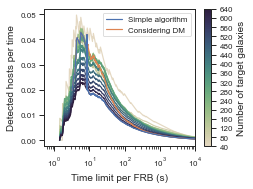

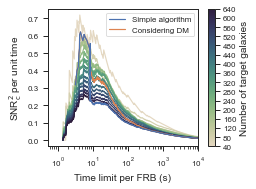

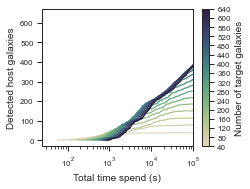

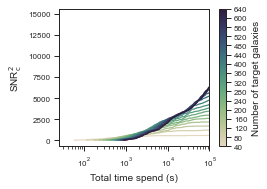

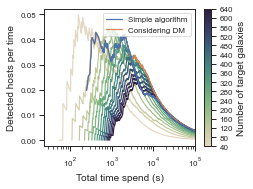

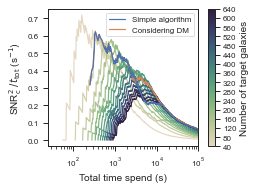

In [38]:
# Compare the algorithms with the number
cmap = sns.cubehelix_palette(start=.6, rot=-.9, as_cmap=True)
trace_color = cmap(np.linspace(0, 1, len(n_select)))

for x_axis, y_axis, xlabel, ylabel, fig_name, plt2_data_label in [#[len(n_select)*[time_limit], n_observed, "Time limit per FRB (s)", "Detected host galaxies"],
         [len(n_select)*[time_limit], n_observed/total_time, "Time limit per FRB (s)", "Detected hosts per time", "n_gal_vs_ndetected_vs_limit", [time_limits[:], n_obsed[:]/t_tot[:], time_limits2[:], n_obsed2[:]/t_tot2[:]]],
         [len(n_select)*[time_limit], n_weighted/total_time, "Time limit per FRB (s)", "SNR$_\mathrm{c}^2$ per unit time", "n_gal_vs_signal_vs_limit", [time_limits[:], c_signal[:]/t_tot[:], time_limits2[:], c_signal2[:]/t_tot2[:]]],
         [total_time, n_observed, "Total time spend (s)", "Detected host galaxies", "n_gal_vs_ndetected_vs_time", None],
         [total_time, n_weighted, "Total time spend (s)", "SNR$_\mathrm{c}^2$", "n_gal_vs_signal_vs_time", None],
         [total_time, n_observed/total_time, "Total time spend (s)", "Detected hosts per time", "n_gal_vs_n_per_time_vs_time", [t_tot, n_obsed/t_tot, t_tot2, n_obsed2/t_tot2]],
         [total_time, n_weighted/total_time, "Total time spend (s)", "SNR$_\mathrm{c}^2$ $/ t_\mathrm{tot}$ (s$^{-1}$)", "n_gal_vs_s_per_time_vs_time", [t_tot, c_signal/t_tot, t_tot2, c_signal2/t_tot2]],
        ]:

    fig, ax = plt.subplots(figsize=(columnwidth, columnwidth*4.8/6.4))

    for j, num in enumerate(n_select):
        ax.plot(x_axis[j], y_axis[j], color=trace_color[j])
    if plt2_data_label:
        x1, y1, x2, y2 = plt2_data_label
        plt.plot(x1, y1, label="Simple algorithm", zorder=3)
        plt.plot(x2, y2, label="Considering DM", zorder=2)
        plt.legend()

    ax.set_xscale('log')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    mapp = ScalarMappable(cmap=cmap, norm=plt.Normalize(n_select.min(), n_select.max()))
    cbar = plt.colorbar(mapp, ticks=n_select[::], label=r'Number of target galaxies')
    if xlabel == "Total time spend (s)":
        ax.set_xlim(None, 1e5)
    else:
        ax.set_xlim(None, 1e4)
    if fig_name:
        fig.savefig(fig_path + fig_name+".png", dpi=300, bbox_inches='tight')

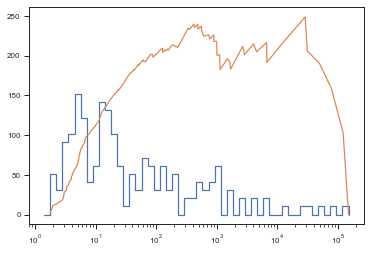

In [39]:
# Plot a DM histogram against the algorithms condition
# t = np.logspace(-9, 8, 1000)
t_sorted = obs_time_wo_host[frbs_wo_host['DM'] < 700].sort_values()  # sorted observation times  [frbs_wo_host['DM'] < 700]

t_min, t_max = np.log10(t_sorted.min()), np.log10(t_sorted.max())
bin_num = 50
bin_log_width = (t_max-t_min)/bin_num
t_hist = np.histogram(t_sorted, bins=np.logspace(t_min, t_max, num=bin_num))[0]/bin_log_width  # bins=np.linspace(0, .002)) #*bin_log_width
plt.step([10**(t_min-bin_log_width)]+list(np.logspace(t_min, t_max, num=bin_num)), [0]+list(t_hist)+[0], where='post')

plt.xscale('log')
N = len(t_sorted)  # total number of targets
n = np.arange(1, N+.1)
# plt.vlines(np.logspace(t_min, t_max), 0, 50)
plt.plot(t_sorted[:200], (n*(N-n)*t_sorted*np.log(10)/(t_sorted.cumsum()+t_sorted*(N-n)))[:200]) #
# plt.xlim(1e-9, 1e-4)
# plt.ylim(None, 50)

(0.0, 50.0)

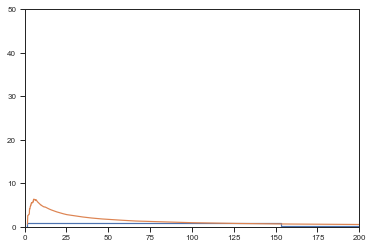

In [40]:
# Plot the same in linspace.
# t = np.logspace(-9, 8, 1000)
t_sorted = obs_time_wo_host[frbs_wo_host['DM'] < 700].sort_values()  # sorted observation times  [frbs_wo_host['DM'] < 700]

t_min, t_max = t_sorted.min(), t_sorted.max()
bin_num = 1000
bin_log_width = (t_max-t_min)/bin_num
t_hist = np.histogram(t_sorted, bins=np.linspace(t_min, t_max, num=bin_num))[0]/bin_log_width  # bins=np.linspace(0, .002)) #*bin_log_width
plt.step([t_min-bin_log_width]+list(np.linspace(t_min, t_max, num=bin_num)), [0]+list(t_hist)+[0], where='post')
# plt.plot(t_sorted, lognorm()
# plt.xscale('log')
N = len(t_sorted)  # total number of targets
n = np.arange(1, N+.1)
# plt.vlines(np.logspace(t_min, t_max), 0, 50)
plt.plot(t_sorted[:], (n*(N-n)/(t_sorted.cumsum()+t_sorted*(N-n)))[:]) #
plt.xlim(0, 200)  # plt.xlim(1e-9, 1e-4)
plt.ylim(0, 50)